# Imports

In [1]:
!pip install --upgrade tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget --output-document=ml-1m.zip http://www.grouplens.org/system/files/ml-1m.zip; unzip ml-1m.zip

--2022-06-04 15:06:20--  http://www.grouplens.org/system/files/ml-1m.zip
Resolving www.grouplens.org (www.grouplens.org)... 128.101.34.235
Connecting to www.grouplens.org (www.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://grouplens.org/system/files/ml-1m.zip [following]
--2022-06-04 15:06:20--  https://grouplens.org/system/files/ml-1m.zip
Resolving grouplens.org (grouplens.org)... 128.101.34.235
Connecting to grouplens.org (grouplens.org)|128.101.34.235|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://files.grouplens.org/papers/ml-1m.zip [following]
--2022-06-04 15:06:21--  http://files.grouplens.org/papers/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zi

# Functions

In [3]:
import numpy as np
from time import time


def loadData(path='./', valfrac=0.1, delimiter='::', seed=1234,
             transpose=False):
    '''
    loads ml-1m data
    :param path: path to the ratings file
    :param valfrac: fraction of data to use for validation
    :param delimiter: delimiter used in data file
    :param seed: random seed for validation splitting
    :param transpose: flag to transpose output matrices (swapping users with movies)
    :return: train ratings (n_u, n_m), valid ratings (n_u, n_m)
    '''
    np.random.seed(seed)

    tic = time()
    print('reading data...')
    data = np.loadtxt(path, skiprows=0, delimiter=delimiter).astype('int32')
    print('data read in', time() - tic, 'seconds')

    n_u = np.unique(data[:, 0]).shape[0]  # number of users
    n_m = np.unique(data[:, 1]).shape[0]  # number of movies
    n_r = data.shape[0]  # number of ratings

    # these dictionaries define a mapping from user/movie id to to user/movie number (contiguous from zero)
    udict = {}
    for i, u in enumerate(np.unique(data[:, 0]).tolist()):
        udict[u] = i
    mdict = {}
    for i, m in enumerate(np.unique(data[:, 1]).tolist()):
        mdict[m] = i

    # shuffle indices
    idx = np.arange(n_r)
    np.random.shuffle(idx)

    trainRatings = np.zeros((n_u, n_m), dtype='float32')
    validRatings = np.zeros((n_u, n_m), dtype='float32')

    for i in range(n_r):
        u_id = data[idx[i], 0]
        m_id = data[idx[i], 1]
        r = data[idx[i], 2]

        # the first few ratings of the shuffled data array are validation data
        if i <= valfrac * n_r:
            validRatings[udict[u_id], mdict[m_id]] = int(r)
        # the rest are training data
        else:
            trainRatings[udict[u_id], mdict[m_id]] = int(r)

    if transpose:
        trainRatings = trainRatings.T
        validRatings = validRatings.T

    print('loaded dense data matrix')

    return trainRatings, validRatings


Функция для графика ошибок

In [ ]:
from matplotlib import pyplot as plt

def error_plot(er_v, er_t, n):
    epoch = []
    for i in range(n):
      epoch.append(i)
    plt.figure(figsize=(16, 8))
    plt.title('График зависимости ошибок от эпохи')
    plt.plot(epoch, er_v, c='k')
    plt.plot(epoch, er_t, c='b')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['validation error', 'train error'])
    plt.show()

# Teacher model X

Обучаем среднюю модель (n_hid = 250, n_layers = 2)

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from time import time
import sys
import os

seed = int(time())
np.random.seed(seed)
data =[]

er_v = []
er_t = []

# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::',
                  seed=seed, transpose=True, valfrac=0.1)

tm = np.greater(tr, 1e-12).astype('float32')  # masks indicating non-zero entries
vm = np.greater(vr, 1e-12).astype('float32')

n_m = tr.shape[0]  # number of movies
n_u = tr.shape[1]  # number of users (may be switched depending on 'transpose' in loadData)

# Set hyper-parameters
argv = [1488, 60, 0.013]
n_hid = 250 #250
lambda_2 = float(argv[1]) if len(argv) > 1 else 60.
lambda_s = float(argv[2]) if len(argv) > 2 else 0.013
n_layers = 2 #1
output_every = 50  # evaluate performance on test set; breaks l-bfgs loop
n_epoch = n_layers * 10 * output_every
verbose_bfgs = True
use_gpu = True
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    
# Input placeholders
R = tf.placeholder("float", [None, n_u])


# define network functions
def kernel(u, v):
    """
    Sparsifying kernel function
    :param u: input vectors [n_in, 1, n_dim]
    :param v: output vectors [1, n_hid, n_dim]
    :return: input to output connection matrix
    """
    dist = tf.norm(u - v, ord=2, axis=2)
    hat = tf.maximum(0., 1. - dist**2)
    return hat


def kernel_layer(x, n_hid=500, n_dim=5, activation=tf.nn.sigmoid, lambda_s=lambda_s,
                 lambda_2=lambda_2, name=''):
    """
    a kernel sparsified layer
    :param x: input [batch, channels]
    :param n_hid: number of hidden units
    :param n_dim: number of dimensions to embed for kernelization
    :param activation: output activation
    :param name: layer name for scoping
    :return: layer output, regularization term
    """

    # define variables
    with tf.variable_scope(name):
        W = tf.get_variable('W', [x.shape[1], n_hid])
        n_in = x.get_shape().as_list()[1]
        u = tf.get_variable('u', initializer=tf.random.truncated_normal([n_in, 1, n_dim], 0., 1e-3))
        v = tf.get_variable('v', initializer=tf.random.truncated_normal([1, n_hid, n_dim], 0., 1e-3))
        b = tf.get_variable('b', [n_hid])

    # compute sparsifying kernel
    # as u and v move further from each other for some given pair of neurons, their connection
    # decreases in strength and eventually goes to zero.
    w_hat = kernel(u, v)

    # compute regularization terms
    sparse_reg = tf.contrib.layers.l2_regularizer(lambda_s)
    sparse_reg_term = tf.contrib.layers.apply_regularization(sparse_reg, [w_hat])

    l2_reg = tf.contrib.layers.l2_regularizer(lambda_2)
    l2_reg_term = tf.contrib.layers.apply_regularization(l2_reg, [W])

    # compute output
    W_eff = W * w_hat
    y = tf.matmul(x, W_eff) + b
    y = activation(y)
    return y, sparse_reg_term + l2_reg_term


# Instantiate network
y = R
reg_losses = None
for i in range(n_layers):
    y, reg_loss = kernel_layer(y, n_hid, name=str(i))
    reg_losses = reg_loss if reg_losses is None else reg_losses + reg_loss
prediction, reg_loss = kernel_layer(y, n_u, activation=tf.identity, name='out')
reg_losses = reg_losses + reg_loss

# Compute loss (symbolic)
diff = tm*(R - prediction)
sqE = tf.nn.l2_loss(diff)
loss = sqE + reg_losses

# Instantiate L-BFGS Optimizer
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': output_every,
                                                                  'disp': verbose_bfgs,
                                                                  'maxcor': 10},
                                                   method='L-BFGS-B')

# Training and validation loop
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(int(n_epoch / output_every)):
        optimizer.minimize(sess, feed_dict={R: tr}) #do maxiter optimization steps
        pre = sess.run(prediction, feed_dict={R: tr}) #predict ratings (pre + tr)

        error = (vm * (np.clip(pre, 1., 5.) - vr) ** 2).sum() / vm.sum() #compute validation error
        error_train = (tm * (np.clip(pre, 1., 5.) - tr) ** 2).sum() / tm.sum() #compute train error
        er_v.append(np.sqrt(error))
        er_t.append(np.sqrt(error_train))

        print('.-^-._' * 12)
        print('epoch:', i, 'validation rmse:', np.sqrt(error), 'train rmse:', np.sqrt(error_train))
        print('.-^-._' * 12)

    with open('summary_ml1m.txt', 'a') as file:
        for a in sys.argv[1:]:
            file.write(a + ' ')
        file.write(str(np.sqrt(error)) + ' ' + str(np.sqrt(error_train))
                   + ' ' + str(seed) + '\n')
        file.close()

reading data...
data read in 11.969686269760132 seconds
loaded dense data matrix
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 403830.125000
  Number of iterations: 50
  Number of functions evaluations: 54
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
epoch: 0 validation rmse: 0.8871171 train rmse: 0.87454367
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
INFO:tensorflow:Optimization terminated with:

График для средней модели(n_hid = 250, n_layers = 2)

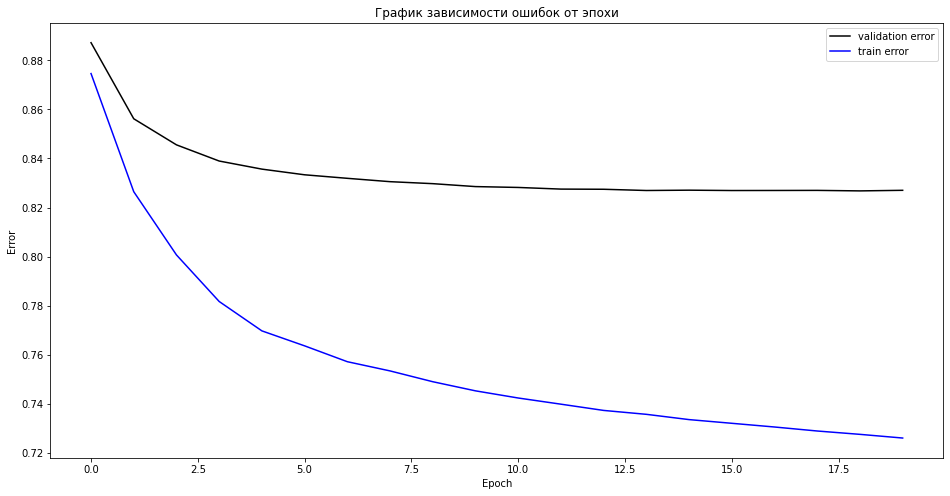

In [14]:
error_plot(er_v, er_t, 20)

# Teacher model Y

Теперь обучим большую модель(n_hid = 500, n_layers = 2)  
P.S. Перед обучением новой модели стоит перезапустить среду

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from time import time
import sys
import os

seed = int(time())
np.random.seed(seed)
data =[]

er_v = []
er_t = []

# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::',
                  seed=seed, transpose=True, valfrac=0.1)

tm = np.greater(tr, 1e-12).astype('float32')  # masks indicating non-zero entries
vm = np.greater(vr, 1e-12).astype('float32')

n_m = tr.shape[0]  # number of movies
n_u = tr.shape[1]  # number of users (may be switched depending on 'transpose' in loadData)

# Set hyper-parameters
argv = [1488, 60, 0.013]
n_hid = 500 #250
lambda_2 = float(argv[1]) if len(argv) > 1 else 60.
lambda_s = float(argv[2]) if len(argv) > 2 else 0.013
n_layers = 2 #1
output_every = 50  # evaluate performance on test set; breaks l-bfgs loop
n_epoch = n_layers * 10 * output_every
verbose_bfgs = True
use_gpu = True
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    
# Input placeholders
R = tf.placeholder("float", [None, n_u])


# define network functions
def kernel(u, v):
    """
    Sparsifying kernel function
    :param u: input vectors [n_in, 1, n_dim]
    :param v: output vectors [1, n_hid, n_dim]
    :return: input to output connection matrix
    """
    dist = tf.norm(u - v, ord=2, axis=2)
    hat = tf.maximum(0., 1. - dist**2)
    return hat


def kernel_layer(x, n_hid=500, n_dim=5, activation=tf.nn.sigmoid, lambda_s=lambda_s,
                 lambda_2=lambda_2, name=''):
    """
    a kernel sparsified layer
    :param x: input [batch, channels]
    :param n_hid: number of hidden units
    :param n_dim: number of dimensions to embed for kernelization
    :param activation: output activation
    :param name: layer name for scoping
    :return: layer output, regularization term
    """

    # define variables
    with tf.variable_scope(name):
        W = tf.get_variable('W', [x.shape[1], n_hid])
        n_in = x.get_shape().as_list()[1]
        u = tf.get_variable('u', initializer=tf.random.truncated_normal([n_in, 1, n_dim], 0., 1e-3))
        v = tf.get_variable('v', initializer=tf.random.truncated_normal([1, n_hid, n_dim], 0., 1e-3))
        b = tf.get_variable('b', [n_hid])

    # compute sparsifying kernel
    # as u and v move further from each other for some given pair of neurons, their connection
    # decreases in strength and eventually goes to zero.
    w_hat = kernel(u, v)

    # compute regularization terms
    sparse_reg = tf.contrib.layers.l2_regularizer(lambda_s)
    sparse_reg_term = tf.contrib.layers.apply_regularization(sparse_reg, [w_hat])

    l2_reg = tf.contrib.layers.l2_regularizer(lambda_2)
    l2_reg_term = tf.contrib.layers.apply_regularization(l2_reg, [W])

    # compute output
    W_eff = W * w_hat
    y = tf.matmul(x, W_eff) + b
    y = activation(y)
    return y, sparse_reg_term + l2_reg_term


# Instantiate network
y = R
reg_losses = None
for i in range(n_layers):
    y, reg_loss = kernel_layer(y, n_hid, name=str(i))
    reg_losses = reg_loss if reg_losses is None else reg_losses + reg_loss
prediction, reg_loss = kernel_layer(y, n_u, activation=tf.identity, name='out')
reg_losses = reg_losses + reg_loss

# Compute loss (symbolic)
diff = tm*(R - prediction)
sqE = tf.nn.l2_loss(diff)
loss = sqE + reg_losses

# Instantiate L-BFGS Optimizer
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': output_every,
                                                                  'disp': verbose_bfgs,
                                                                  'maxcor': 10},
                                                   method='L-BFGS-B')

# Training and validation loop
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(int(n_epoch / output_every)):
        optimizer.minimize(sess, feed_dict={R: tr}) #do maxiter optimization steps
        pre = sess.run(prediction, feed_dict={R: tr}) #predict ratings (pre + tr)

        error = (vm * (np.clip(pre, 1., 5.) - vr) ** 2).sum() / vm.sum() #compute validation error
        error_train = (tm * (np.clip(pre, 1., 5.) - tr) ** 2).sum() / tm.sum() #compute train error
        er_v.append(np.sqrt(error))
        er_t.append(np.sqrt(error_train))

        print('.-^-._' * 12)
        print('epoch:', i, 'validation rmse:', np.sqrt(error), 'train rmse:', np.sqrt(error_train))
        print('.-^-._' * 12)

    with open('summary_ml1m.txt', 'a') as file:
        for a in sys.argv[1:]:
            file.write(a + ' ')
        file.write(str(np.sqrt(error)) + ' ' + str(np.sqrt(error_train))
                   + ' ' + str(seed) + '\n')
        file.close()

reading data...
data read in 6.575781345367432 seconds
loaded dense data matrix
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 438197.125000
  Number of iterations: 50
  Number of functions evaluations: 54
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
epoch: 0 validation rmse: 0.8832774 train rmse: 0.8677439
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
INFO:tensorflow:Optimization terminated with:
 

График для большой модели(n_hid = 500, n_layers = 2)

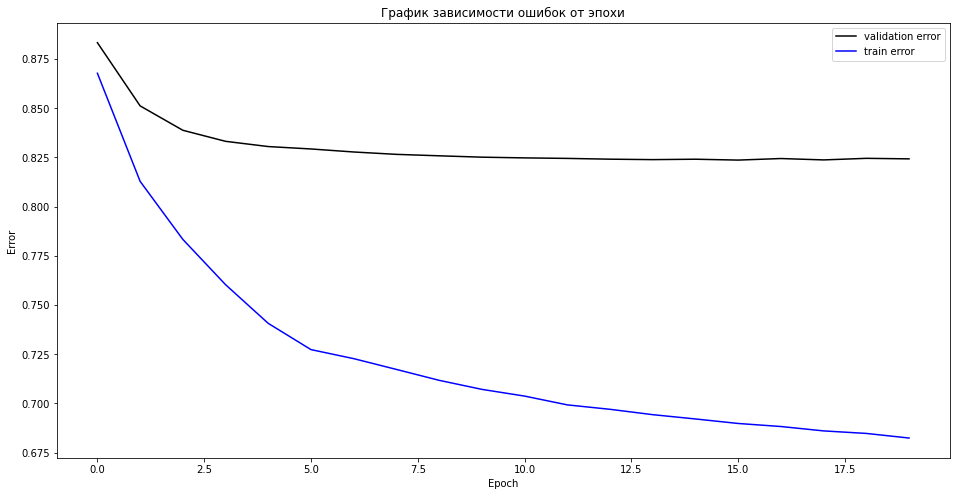

In [7]:
error_plot(er_v, er_t, 20)

# Saving pre from teacher model Y

Сохраняем предсказания большой модели


In [8]:
f = open('prediction.txt', 'w')
for i in pre:
    for j in i:
        f.write(str(j))
        f.write(' ')
    f.write('\n')
f.close()

Перезапускаем среду


# Geting data from prediction model Y

Достаем предсказания большой модели, чтобы на них обучить маленькую

In [5]:
f = open('prediction.txt')
matrix = [line.replace("\n", "").split() for line in f]
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        matrix[i][j] = float(matrix[i][j])
f.close()

# Student model Z (from teacger Y)

Обучаем маленькую (n_hid = 100, n_layers = 1) модель на предсказании средней

In [7]:
import numpy as np
import tensorflow as tf
from time import time
import sys
import os

seed = int(time())
np.random.seed(seed)
data = []

er_v = []
er_t = []

# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::',
                  seed=seed, transpose=True, valfrac=0.1)

tm = np.greater(tr, 1e-12).astype('float32')  # masks indicating non-zero entries
vm = np.greater(vr, 1e-12).astype('float32')

n_m = tr.shape[0]  # number of movies
n_u = tr.shape[1]  # number of users (may be switched depending on 'transpose' in loadData)

# Set hyper-parameters
argv = [1488, 60, 0.013]
n_hid = 100 #250
lambda_2 = float(argv[1]) if len(argv) > 1 else 60.
lambda_s = float(argv[2]) if len(argv) > 2 else 0.013
n_layers = 1 #1
output_every = 50  # evaluate performance on test set; breaks l-bfgs loop
n_epoch = n_layers * 10 * output_every
verbose_bfgs = True
use_gpu = True
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    
# Input placeholders
R = tf.placeholder("float", [None, n_u])


# define network functions
def kernel(u, v):
    """
    Sparsifying kernel function
    :param u: input vectors [n_in, 1, n_dim]
    :param v: output vectors [1, n_hid, n_dim]
    :return: input to output connection matrix
    """
    dist = tf.norm(u - v, ord=2, axis=2)
    hat = tf.maximum(0., 1. - dist**2)
    return hat


def kernel_layer(x, n_hid=500, n_dim=5, activation=tf.nn.sigmoid, lambda_s=lambda_s,
                 lambda_2=lambda_2, name=''):
    """
    a kernel sparsified layer
    :param x: input [batch, channels]
    :param n_hid: number of hidden units
    :param n_dim: number of dimensions to embed for kernelization
    :param activation: output activation
    :param name: layer name for scoping
    :return: layer output, regularization term
    """

    # define variables
    with tf.variable_scope(name):
        W = tf.get_variable('W', [x.shape[1], n_hid])
        n_in = x.get_shape().as_list()[1]
        u = tf.get_variable('u', initializer=tf.random.truncated_normal([n_in, 1, n_dim], 0., 1e-3))
        v = tf.get_variable('v', initializer=tf.random.truncated_normal([1, n_hid, n_dim], 0., 1e-3))
        b = tf.get_variable('b', [n_hid])

    # compute sparsifying kernel
    # as u and v move further from each other for some given pair of neurons, their connection
    # decreases in strength and eventually goes to zero.
    w_hat = kernel(u, v)

    # compute regularization terms
    sparse_reg = tf.contrib.layers.l2_regularizer(lambda_s)
    sparse_reg_term = tf.contrib.layers.apply_regularization(sparse_reg, [w_hat])

    l2_reg = tf.contrib.layers.l2_regularizer(lambda_2)
    l2_reg_term = tf.contrib.layers.apply_regularization(l2_reg, [W])

    # compute output
    W_eff = W * w_hat
    y = tf.matmul(x, W_eff) + b
    y = activation(y)
    return y, sparse_reg_term + l2_reg_term


# Instantiate network
y = R
reg_losses = None
for i in range(n_layers):
    y, reg_loss = kernel_layer(y, n_hid, name=str(i))
    reg_losses = reg_loss if reg_losses is None else reg_losses + reg_loss
prediction, reg_loss = kernel_layer(y, n_u, activation=tf.identity, name='out')
reg_losses = reg_losses + reg_loss

# Compute loss (symbolic)
diff = tm*(R - prediction)
sqE = tf.nn.l2_loss(diff)
loss = sqE + reg_losses

# Instantiate L-BFGS Optimizer
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': output_every,
                                                                  'disp': verbose_bfgs,
                                                                  'maxcor': 10},
                                                   method='L-BFGS-B')

# Training and validation loop
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(int(n_epoch / output_every)):
        optimizer.minimize(sess, feed_dict={R: matrix}) #do maxiter optimization steps
        pre = sess.run(prediction, feed_dict={R: tr}) #predict ratings (pre + tr)

        error = (vm * (np.clip(pre, 1., 5.) - vr) ** 2).sum() / vm.sum() #compute validation error
        error_train = (tm * (np.clip(pre, 1., 5.) - tr) ** 2).sum() / tm.sum() #compute train error
        er_v.append(np.sqrt(error))
        er_t.append(np.sqrt(error_train))

        print('.-^-._' * 12)
        print('epoch:', i, 'validation rmse:', np.sqrt(error), 'train rmse:', np.sqrt(error_train))
        print('.-^-._' * 12)

    with open('summary_ml1m.txt', 'a') as file:
        for a in sys.argv[1:]:
            file.write(a + ' ')
        file.write(str(np.sqrt(error)) + ' ' + str(np.sqrt(error_train))
                   + ' ' + str(seed) + '\n')
        file.close()

reading data...
data read in 6.52471399307251 seconds
loaded dense data matrix
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 284095.125000
  Number of iterations: 50
  Number of functions evaluations: 70
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
epoch: 0 validation rmse: 1.0326216 train rmse: 1.0278858
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
INFO:tensorflow:Optimization terminated with:
  

График ошибок для маленькой модели + дистилляция

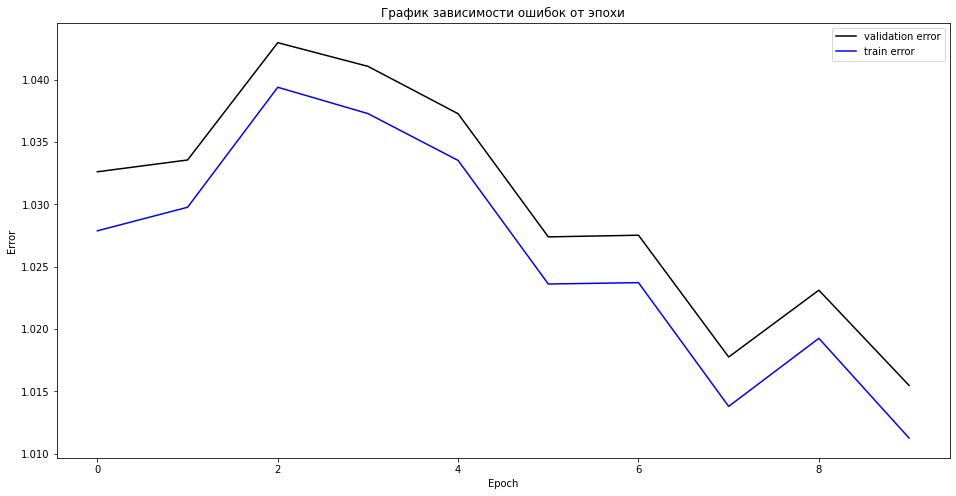

In [10]:
error_plot(er_v, er_t, 10)